# Inject data into PostgreSQL

In [19]:
import pandas as pd
from sqlalchemy import create_engine

# PostgreSQL connection details
db_user = 'postgres'
db_password = 'admin'
db_host = 'localhost'  # or remote host
db_port = '5433'
db_name = 'myDatabase'

# Create connection string
engine = create_engine(f'postgresql+psycopg2://{db_user}:{db_password}@{db_host}:{db_port}/{db_name}')

# Read CSV files
energy_df = pd.read_csv("Energy_Usage_Dataset.csv")
performance_df = pd.read_csv("Server_Performance_Dataset.csv")
vendor_df = pd.read_csv("Vendor_Details_Dataset.csv")

# Optional cleaning (e.g., rename columns to match SQL standards)
#energy_df.columns = [col.strip().lower().replace(" ", "_").replace("(", "").replace(")", "") for col in energy_df.columns]
#performance_df.columns = [col.strip().lower().replace(" ", "_").replace("(", "").replace(")", "") for col in performance_df.columns]
#vendor_df.columns = [col.strip().lower().replace(" ", "_").replace("(", "").replace(")", "") for col in vendor_df.columns]

# Load to PostgreSQL (replace if exists)
energy_df.to_sql("Energy_Usage", engine, if_exists='replace', index=False)
performance_df.to_sql("Server_Performance", engine, if_exists='replace', index=False)
vendor_df.to_sql("Vendor_Details", engine, if_exists='replace', index=False)

print("Data loaded successfully into PostgreSQL!")


Data loaded successfully into PostgreSQL!


# Load data from PostgreSQL

In [20]:
# Load tables into DataFrames
energy_df = pd.read_sql('SELECT * FROM "Energy_Usage"', engine)
performance_df = pd.read_sql('SELECT * FROM "Server_Performance"', engine)
vendor_df = pd.read_sql('SELECT * FROM "Vendor_Details"', engine)

# EDA Starts from here

In [21]:
# Print basic info
print("Energy Usage:\n", energy_df.info())
print("\nServer Performance:\n", performance_df.info())
print("\nVendor Details:\n", vendor_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 18 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Server ID                        5000 non-null   object 
 1   Energy Consumption (kWh)         5000 non-null   float64
 2   Cooling Efficiency (%)           5000 non-null   int64  
 3   Power Usage Effectiveness (PUE)  5000 non-null   float64
 4   Timestamp                        5000 non-null   object 
 5   Server Location                  5000 non-null   object 
 6   Server Type                      5000 non-null   object 
 7   Energy Source                    5000 non-null   object 
 8   Cooling System Type              5000 non-null   object 
 9   Energy Cost (€)                  5000 non-null   float64
 10  Carbon Emissions (kg CO2)        5000 non-null   float64
 11  Maintenance Status               5000 non-null   object 
 12  Energy Savings Targe

In [22]:
# Missing values
print("\nMissing Values:\n")
print("Energy Usage:\n", energy_df.isnull().sum())
print("\nServer Performance:\n", performance_df.isnull().sum())
print("\nVendor Details:\n", vendor_df.isnull().sum())


Missing Values:

Energy Usage:
 Server ID                          0
Energy Consumption (kWh)           0
Cooling Efficiency (%)             0
Power Usage Effectiveness (PUE)    0
Timestamp                          0
Server Location                    0
Server Type                        0
Energy Source                      0
Cooling System Type                0
Energy Cost (€)                    0
Carbon Emissions (kg CO2)          0
Maintenance Status                 0
Energy Savings Target (%)          0
Peak Energy Usage (kWh)            0
Off-Peak Energy Usage (kWh)        0
Year                               0
Month                              0
Day                                0
dtype: int64

Server Performance:
 Server ID                    0
Uptime (%)                   0
Workload (CPU %)             0
Temperature (°C)             0
Timestamp                    0
Server Location              0
Server Type                  0
Memory Usage (%)             0
Disk Usage (%)    

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import numpy as np

import warnings

# Suppress all warnings
warnings.filterwarnings('ignore')

   Year  Energy Consumption (kWh)
0  2020                 469003.87
1  2021                 482900.68
2  2022                 459876.83
3  2023                 458890.28
4  2024                 501994.93
5  2025                 126571.09


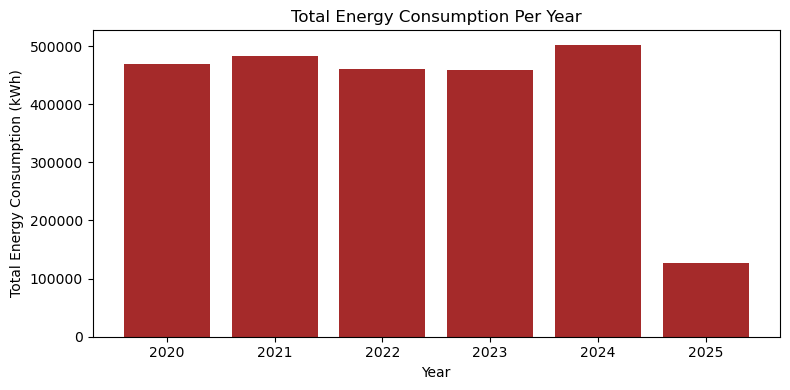

In [24]:
# Convert 'Timestamp' to datetime if not already
energy_df['Timestamp'] = pd.to_datetime(energy_df['Timestamp'])

# Extract year from Timestamp
energy_df['Year'] = energy_df['Timestamp'].dt.year

# Group by Year and sum energy consumption
yearly_energy_consumption = energy_df.groupby('Year')['Energy Consumption (kWh)'].sum().reset_index()

# Display DataFrame with total energy consumption per year
print(yearly_energy_consumption)

# Plot Total Energy Consumption per Year
plt.figure(figsize=(8, 4))
plt.bar(yearly_energy_consumption['Year'], yearly_energy_consumption['Energy Consumption (kWh)'], color='brown')
plt.xlabel("Year")
plt.ylabel("Total Energy Consumption (kWh)")
plt.title("Total Energy Consumption Per Year")
plt.xticks(yearly_energy_consumption['Year'])
plt.tight_layout()
plt.show()

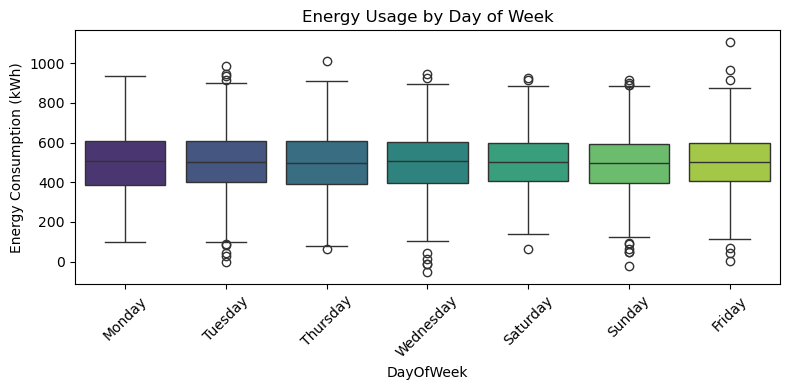

In [25]:
# 2. Boxplot: Energy Usage by Day of Week
energy_df['DayOfWeek'] = pd.to_datetime(energy_df['Timestamp']).dt.day_name()

plt.figure(figsize=(8, 4))
sns.boxplot(data=energy_df, x='DayOfWeek', y='Energy Consumption (kWh)', palette='viridis')
plt.title("Energy Usage by Day of Week")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

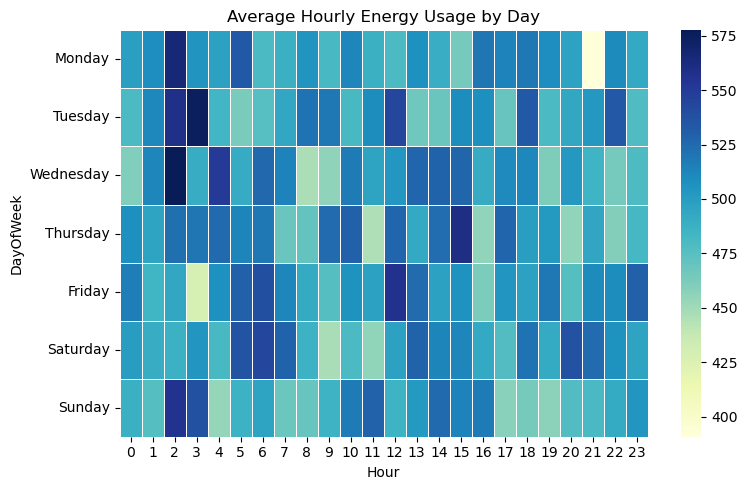

In [26]:
# 3. Heatmap: Hourly Energy Usage by Day
energy_df['Hour'] = pd.to_datetime(energy_df['Timestamp']).dt.hour
pivot_table = energy_df.pivot_table(index='DayOfWeek', columns='Hour', values='Energy Consumption (kWh)', aggfunc='mean')

# Reorder days
ordered_days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
pivot_table = pivot_table.reindex(ordered_days)

plt.figure(figsize=(8, 5))
sns.heatmap(pivot_table, cmap='YlGnBu', linewidths=0.5)
plt.title("Average Hourly Energy Usage by Day")
plt.tight_layout()
plt.show()


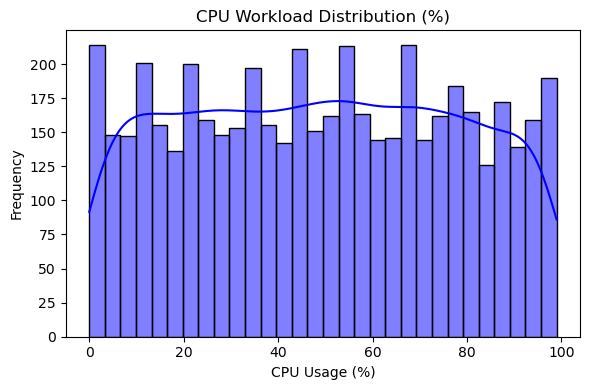

In [27]:
# 4. Scatter Plot: CPU Workload vs Energy Usage (merged)
plt.figure(figsize=(6, 4))
sns.histplot(performance_df['Workload (CPU %)'], bins=30, kde=True, color='blue')
plt.title("CPU Workload Distribution (%)")
plt.xlabel("CPU Usage (%)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

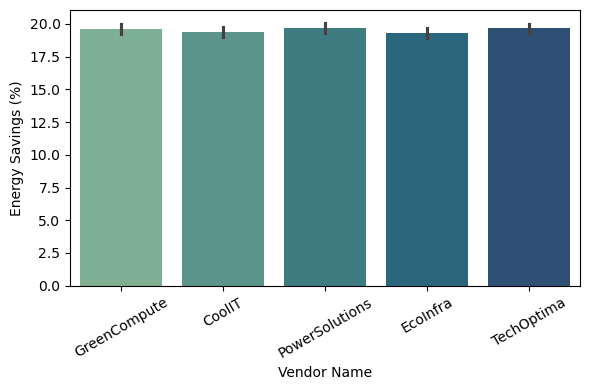

In [31]:
# 5. Energy Savings by Vendor
plt.figure(figsize=(6, 4))
sns.barplot(data=vendor_df, x='Vendor Name', y='Energy Savings (%)', palette='crest')
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

In [44]:
# 6. Vendor Rating Distribution with respect to vendor name

vendor_rating_avg = vendor_df.groupby('Vendor Name')['Vendor Rating (1-5)'].mean().reset_index()

fig = px.pie(
    vendor_rating_avg,
    names='Vendor Name',
    values='Vendor Rating (1-5)',
    title='Vendor Rating Distribution',
    color_discrete_sequence=px.colors.sequential.Viridis,
    width=450, height=400  # Smaller size
)

fig.update_traces(
    textinfo='percent+label',
    hovertemplate='<b>%{label}</b><br>Rating Share: %{percent}<br>Avg Rating: %{value:.2f}'
)

fig.show()

In [40]:
# 7. Carbon Emissions distribution by Server Location

# Group by location and sum the emissions
location_emissions = energy_df.groupby('Server Location')['Carbon Emissions (kg CO2)'].sum().reset_index()

fig = px.pie(
    location_emissions,
    names='Server Location',
    values='Carbon Emissions (kg CO2)',
    title='Carbon Emissions by Server Location',
    color_discrete_sequence=px.colors.sequential.Magma,
    width=500, height=400
)

fig.update_traces(
    textinfo='percent+label',
    hovertemplate='<b>%{label}</b><br>Carbon Emissions: %{value:.2f} kg<extra></extra>'
)

fig.show()

In [41]:
# 8. Energy Consumption distribution by Server Location

# Group by location and sum the emissions
location_emissions = energy_df.groupby('Server Location')['Energy Consumption (kWh)'].sum().reset_index()

fig = px.pie(
    location_emissions,
    names='Server Location',
    values='Energy Consumption (kWh)',
    title='Energy Consumption by Server Location',
    color_discrete_sequence=px.colors.sequential.Magma,
    width=500, height=400
)

fig.update_traces(
    textinfo='percent+label',
    hovertemplate='<b>%{label}</b><br>Total Energy Consumption(kWh): %{value:.2f}<extra></extra>'
)

fig.show()

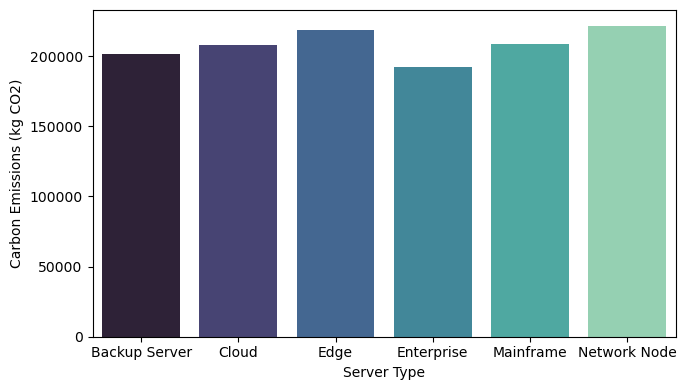

In [43]:
# 9. Carbon Emissions by Server Type

srver_emissions = energy_df.groupby('Server Type')['Carbon Emissions (kg CO2)'].sum().reset_index()

# Plot
plt.figure(figsize=(7, 4))
sns.barplot(data=srver_emissions, x='Server Type', y='Carbon Emissions (kg CO2)', palette='mako')
plt.xlabel("Server Type")
plt.ylabel("Carbon Emissions (kg CO2)")
plt.tight_layout()
plt.show()
